This pairs research explore differnece in price and return correlation when determining if equities may be good pairs trades.

Specifically we are testing the correlation between two student loan stocks 

In [147]:
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns

In [159]:
data=pd.DataFrame()
sd='2014-05-01'
ed='2017-04-10'
fq='daily'
SLM =get_pricing('SLM',start_date=sd,end_date=ed,frequency=fq)
NAVI=get_pricing('NAVI',start_date=sd,end_date=ed,frequency=fq)
slm =SLM['close_price']
navi=NAVI['close_price']

data=pd.concat([navi,slm],keys=["navi_price","slm_price"],axis=1)

#write function for this 

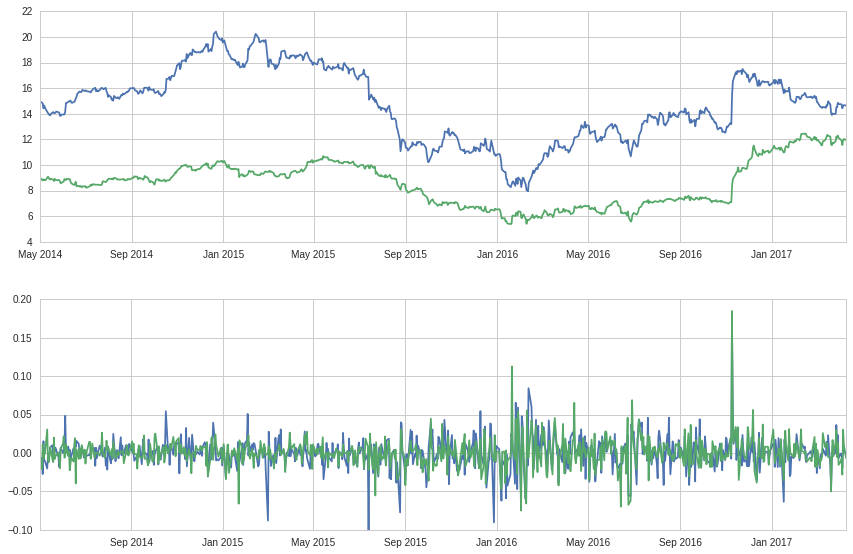

In [169]:
data['navi_day']=data.navi_price.pct_change()          #daily change
data['slm_day']=data.slm_price.pct_change()            #daily change 
data['navi_cum']=data.navi_price.pct_change().cumsum() #cummulative returns
data['slm_cum']=data.slm_price.pct_change().cumsum()   #cummulative return


fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],)
ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.4],ylim=(-.1, .2))
x = np.linspace(15,7)
ax1.plot(data[["navi_price","slm_price"]])
ax2.plot(data[["navi_day","slm_day"]])


# Typical Pairs Trading Tests

The pairs trade essentially works by using a linear model for a relationship between the two stock prices:

Typical pair trading test are Pearsons Correlation Coefficent Augmented Dickey Fuller Test, Hurst Exponent, and Cointegration. We will do all of these eventually but for now we will run a quick test to see if the daily return prices are correlated then continue with price based analysis



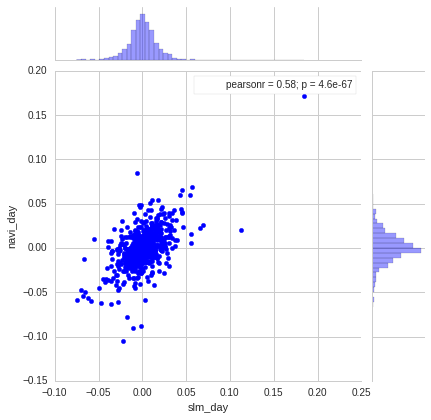

Pearson Correlation Coefficent Daily Return NAVI_SLM = 0.577248712113
 
This suggest that daily returns are not related, but we will test this over multiple day periods too


In [189]:
sns.jointplot(data.slm_day, data.navi_day ,color='b')
plt.show()
print("Pearson Correlation Coefficent Daily Return NAVI_SLM = "+ str(data['navi_day'].corr(data['slm_day'])))
print(" ")
print("This suggest that daily returns are not related, but we will test this over multiple day periods too")
#Here the Correlation is not strong for daily returns

This is a rather weak correlation and suggest that the daily returns are not correlated,and typically we might stop and look for better pairs, but if we look at the price chart comparison there still seems to be a correlation I will go into this further but for now we will continue to with typical pairs trading test

"Now, cointegration tests do not measure how well two variables move together, but rather whether the difference between their means remains constant.

Often, variables with high correlation will also be cointegrated, and vice versa, but this isn’t always the case. In contrast to correlation, when testing for cointegration we use prices rather than returns since we’re more interested in the trend between the variables’ means over time than in the individual price movements"

Lets test this 

What we should find is that these two pairs are not cointegrated because
the difference between their means fluctuates over time. This should be expected because the spread between the two stocks vary widely over time and even goes to 0 at some point in 2018




Is it possible for a pair to fall in and out of cointegration? Needs further testing

https://quantdare.com/correlation-prices-returns/ Testing Prices vs Returns
http://epchan.blogspot.com/2013/11/cointegration-trading-with-log-prices.html Cointegration Log Price vs Prices

https://quantoisseur.com/2017/11/06/cointegration-correlation-and-log-returns/  Cointegration, Correlation, and Log Returns

https://pdfs.semanticscholar.org/ef63/c9574249e9c67c2df6955111814608f60712.pdf (is cointegration really a good indicator? this can be debated due to the fact that the OLS algorithm minimises the squared residuals of the dependent variable in the regression
equation. This has the implication that the coefficients of the two regressions will not be the inverse of the other, i.e. . This in turn has two effects. Firstly, cointegration analysis using OLS will be sensitive to the ordering of variables. )

https://quant.stackexchange.com/questions/41089/minimizing-variance-when-searching-for-cointegration


Stationary vs Cointegration

Tests for Cointegration
To test this we need to caluate their means over time and the spread
As represented in yellow  the difference in their means does not stay constant to   calculate the spread between the means I took a rolling mean of the two prices and subtracted them to find the spread 


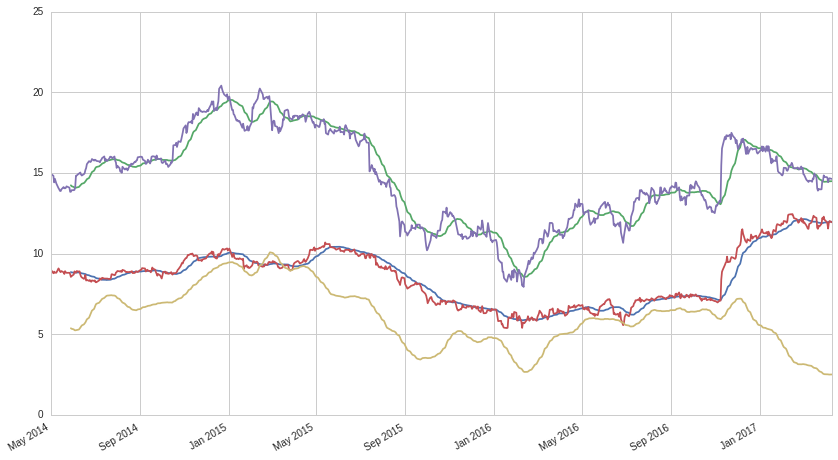

In [208]:
#ointegration tests do not measure how well two variables move together,
#but rather whether the difference between their means remains constant. 
print("Tests for Cointegration")
print("To test this we need to caluate their means over time and the spread")
#monthly20 and more ideal4

#ratio_coint=(data["navi_day"]/data["slm_day"])

data.slm_price.rolling(20).mean().plot()
data.navi_price.rolling(20).mean().plot()
data.slm_price.plot()
data.navi_price.plot()
abs(data.slm_price.rolling(20).mean() - data.navi_price.rolling(20).mean()).plot()

print("As represented in yellow  the difference in their means does not stay constant to   calculate the spread between the means I took a rolling mean of the two prices and subtracted them to find the spread ")


In [212]:
#borrowing some code will quickly calculate ADF and Hurst calcualtion 
df1=data[["slm_price","navi_price"]]
est = sm.OLS(df1.slm_price,df1.navi_price)
est = est.fit()
df1['hr'] = -est.params[0]
df1['spread'] = data.slm_price + (data.navi_price * df1.hr)
                         
cadf = ts.adfuller(df1.spread)
print 'Augmented Dickey Fuller test statistic =',cadf[0]
print 'Augmented Dickey Fuller p-value =',cadf[1]
print 'ADF 1%, 5% and 10% t-stat =',cadf[4]
                         
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values 100 vs 20
    lags = range(2, 20)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print "Hurst Exponent =",round(hurst(df1.spread),2)

Augmented Dickey Fuller test statistic = -0.554568929718
Augmented Dickey Fuller p-value = 0.880920758761
ADF 1%, 5% and 10% t-stat = {'5%': -2.8654483492874236, '1%': -3.4392057325732104, '10%': -2.5688512291811225}
Hurst Exponent = 0.53


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#Quantitaive Results vs Expectations

Tests of the ADF and Hurst Exponent reveal that the price data does not exhibit mean reverting qualities and there fore NAVI and SLM would again not be good candidates for pairs trading. 

These stastical test imply there is no room for statsical arbitrage with these two equities, however how is that two companies with the same business model and similar returns are unrelated.



# Alternative Tests Exploring Returns over Multi Day Periods

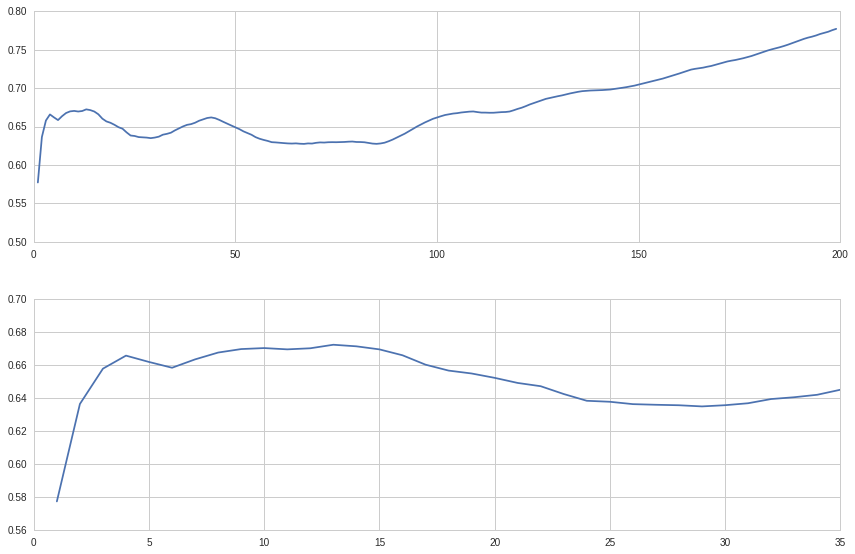

In [213]:
df=pd.concat([navi,slm],keys=["navi_price","slm_price"],axis=1)
params= (0,200,1) 
A = pd.Series(index=range(len(range(params[0],params[1],params[2]))))
for t in range(params[0],params[1],params[2]):
    T = len(range(params[0],params[1],params[2]))
    pct=df.pct_change(periods=t)
    A[t]=pct['navi_price'].corr(pct['slm_price'])
    A.dropna(inplace=True)

    
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],ylim=(.5,.8))
ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.4],ylim=(.56, .7))
x = np.linspace(15,7)
ax1.plot(A)
ax2.plot(A[:35]);

In [214]:
df=pd.concat([navi,slm],keys=["navi_price","slm_price"],axis=1)
params= (0,200,1) 
A = pd.Series(index=range(len(range(params[0],params[1],params[2]))))
def hurst(ts):
    lags = range(2, 100) #20 or 100 not sure what is best 
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

params= (0,200,1) 
A = pd.Series(index=range(len(range(params[0],params[1],params[2]))))
for t in range(params[0],params[1],params[2]):
    T = len(range(params[0],params[1],params[2]))
    pct=df.pct_change(periods=t)
    B=(pct['navi_price'] - pct['slm_price'])
    A[t]=hurst(B)


hurst(spread)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],ylim=(-.1,.6))
ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.4],ylim=(-.1,.5))
x = np.linspace(15,7)
ax1.plot(A)

x = np.linspace(15,7)
ax1.plot(A)
ax2.plot(A[:15]);

NameError: name 'spread' is not defined

In [ ]:
navi_pct=NAVI['close_price'].pct_change(periods=5)
slm_pct=SLM['close_price'].pct_change(periods=5)

#Data
spread = abs((navi_pct - slm_pct))
spread.dropna().describe()

df=pd.concat([navi,slm,spread,z_ratios],keys=["navi_price","slm_price","spread","z_ratio"],axis=1)

##Apply Labels 
df['label'] = 'out of bounds'
df['spread']
df.loc[(df['spread'] > df_describe["value"][4]) 
       &(df['spread'] < df_describe["value"][3]), 'label'] = 'std1_std2' #green

df.loc[(df['spread'] > df_describe["value"][2])
       & (df['spread'] < df_describe["value"][4]), 'label'] = 'q75_std1'  #blue

df.loc[df['spread'] >  df_describe["value"][3], 'label'] = 'greater_std2' # magenta
 
## Convert labels to colors
label2color = {
    'out of bounds': 'grey',
    'greater_std2': 'magenta',
    'q75_std1': 'green',
    'std1_std2': 'blue',
}
df['color'] = df['label'].apply(lambda label: label2color[label])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

navi_pct=NAVI['close_price'].pct_change(periods=5)
slm_pct=SLM['close_price'].pct_change(periods=5)


#Data
spread = abs((navi_pct - slm_pct))
df=pd.concat([navi,slm,spread,z_ratios],keys=["navi_price","slm_price","spread","z_ratio"],axis=1)

##Apply Labels 
df['label'] = 'out of bounds'
df['spread']
df.loc[(df['spread'] > df_describe["value"][4]) &(df['spread'] < df_describe["value"][3]), 'label'] = 'std1_std2' #green
df.loc[(df['spread'] > df_describe["value"][2]) & (df['spread'] < df_describe["value"][4]), 'label'] = 'q75_std1'  #blue
df.loc[df['spread'] >  df_describe["value"][3], 'label'] = 'greater_std2' # magenta

 
## Convert labels to colors
label2color = {
    'out of bounds': 'grey',
    'greater_std2': 'magenta',
    'q75_std1': 'green',
    'std1_std2': 'blue'
}
df['color'] = df['label'].apply(lambda label: label2color[label])
#Apply Markets

# Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)]
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Add px_last lines
for color, start, end in gen_repeating(df['color']):
    if start > 0: # make sure lines connect
        start -= 1
    idx = df.index[start:end+1]
    df.loc[idx, 'navi_price'].plot(ax=ax, color=color, label='')
    df.loc[idx, 'slm_price'].plot(ax=ax, color=color, label='')
    plt.xlim('2014-06-01','2016-04-30')
    

#df.loc[idx, ['navi_price',"slm_price"]].plot(ax=ax, color=color, label='')

## Get artists and labels for legend and chose which ones to display

# Display plot
plt.show()

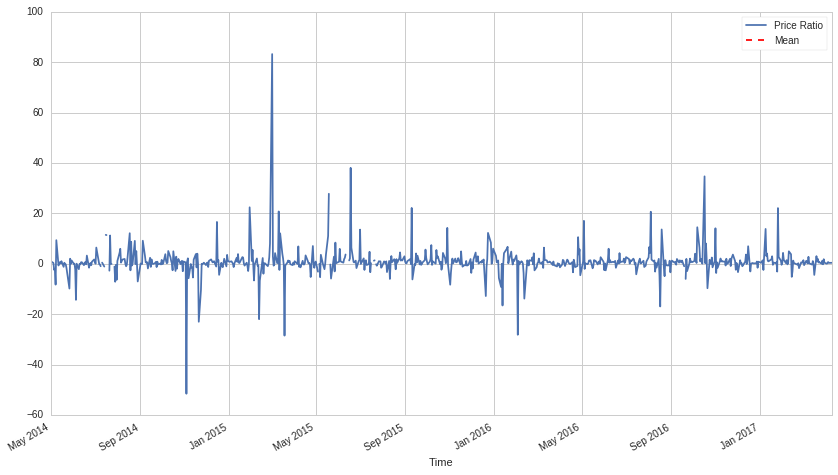

In [215]:
ratio_coint=(data["navi_day"]/data["slm_day"])
#ratio_coint.replace([np.inf, -np.inf], np.nan)
#dropna(inplace=True).describe()

#ratio_coint.plot()
#plt.axhline(ratio_coint.mean(), color='red', linestyle='--')
#plt.xlabel('Time')
#plt.legend(['Price Ratio', 'Mean'])
#plt.show()
#ratio_coint.replace([np.inf, -np.inf], np.nan).dropna(inplace=True).describe()
#ratio_coint=ratio_coint.replace([np.inf, -np.inf], np.nan)
#ratio_coint=ratio_coint.dropna(inplace=True)


df_describe=pd.DataFrame([spread.mean(),
                spread.dropna().describe()[4],
                spread.dropna().describe()[6],
                spread.dropna().describe()[2]*2 + spread.mean(),
                spread.dropna().describe()[2] + spread.mean(),
                spread.dropna().describe()[2],2
                ]
               ,index = ["spread_mean","spread_Q25","spread_Q75","mean + st2","mean + st1","std","z_score"],columns=["value"])
df_describe

In [180]:
#return correlation vs price correlation

In [ ]:
data = pd.DataFrame()
stocks = ['AAPL', 'ADBE', 'SYMC', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM']
stocks.count()

#def get_close(stocks):
get_close(stocks)

for i in range(0,len(stocks)):
    dat=get_pricing(stocks,start_date=sd,end_date=ed,frequency=fq) 
    dat.head()


#for i in range(0,len(stocks)):
    #dat=get_pricing(stocks[i],start_date=sd,end_date=ed,frequency=fq) 
    #df=dat['close_price']
print(dat.head())




#prices = {'apple': 0.40, 'orange': 0.35, 'banana': 0.25}
#for k, v in prices.items():
#     prices[k] = round(v * 0.9, 2)  # Apply a 10% discount

data = pd.DataFrame()
stocks = ['AAPL', 'ADBE', 'SYMC', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM']
stocks.count()

In [216]:
#Final step of this strategy is to try with intraday trading and larger data set of stocks and implement the strategy
#adding fluctations in US treasuries and intrestrates to the model
#aditional test will utilize price predicition with machine learning 